# Machine Learning Prediction - Data Challenge

## by SNCF-Transilien

Introduction au problème

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') #  entre le 1er janvier 2015 et le 31 décembre 2022 (soit 2922 jours)
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) # entre le 1er janvier 2023 et le 30 juin 2023 (soit 181 jours) 

In [3]:
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
def create_features(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [5]:
def add_lags(df_x, df_y):
    ''' Add lags '''
    target_map = df_y['y'].to_dict()

    df_x['lagDay'] = (
        (df_x.date - pd.DateOffset(days=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)
    
    df_x['lagWeek'] = (
        (df_x.date - pd.DateOffset(days=7))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagMonth'] = (
        (df_x.date - pd.DateOffset(months=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagYear'] = (
        (df_x.date - pd.DateOffset(years=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    return df_x


In [6]:
X_train = create_features(X_train)
X_train = add_lags(X_train, y_train)
X_test = create_features(X_test)
X_test = add_lags(X_test, y_train)

In [7]:
# Drop the 'date' column and convert 'station' to categorical
X_train = X_train.drop(columns=['date'])
X_train['station'] = X_train['station'].astype('category')

# Apply the same preprocessing steps to X_test
X_test = X_test.drop(columns=['date'])
X_test['station'] = X_test['station'].astype('category')

In [8]:
X_train.tail()

,station,job,ferie,vacances,day,month,year,dayofweek,lagDay,lagWeek,lagMonth,lagYear
index,,,,,,,,,,,,
2022-12-31_V2P,V2P,0,0,1,31,12,2022,5,1503.0,1063.0,2205.0,952.0
2022-12-31_N9K,N9K,0,0,1,31,12,2022,5,760.0,417.0,1568.0,376.0
2022-12-31_P6E,P6E,0,0,1,31,12,2022,5,112.0,74.0,350.0,NaN
2022-12-31_BDC,BDC,0,0,1,31,12,2022,5,70.0,53.0,51.0,NaN
2022-12-31_W14,W14,0,0,1,31,12,2022,5,19.0,10.0,59.0,NaN


In [9]:
estimator = lgb.LGBMRegressor(objective='poisson', random_state=42, max_bin=1000, max_depth=10)

param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.1, 0.01, 0.2]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv= KFold(n_splits=4, shuffle=True),
    verbose=100,  
    n_jobs=-1,
).fit(X_train, y_train, eval_set=[(X_train, y_train)])

print("\nBest params:", grid_search.best_params_)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START learning_rate=0.1, n_estimators=1000........................
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4506
[LightGBM] [Info] Number of data points in the train set: 922397, number of used features: 12
[CV 2/4; 1/3] START learning_rate=0.1, n_estimators=1000........................
[LightGBM] [Info] Start training from score 8.277196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4506
[LightGBM] [Info] Number of data points in the train set: 922397, number of used features: 12
[CV 3/4; 1/3] START learning_rate=0.1, n_estimators=1000........................


In [10]:
for p, i in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f'Score {p}: {i}')

Score {'learning_rate': 0.1, 'n_estimators': 1000}: -1430015.2966573709
Score {'learning_rate': 0.01, 'n_estimators': 1000}: -2584304.526076598
Score {'learning_rate': 0.2, 'n_estimators': 1000}: -1515068.2609882378


In [11]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4506
[LightGBM] [Info] Number of data points in the train set: 1229863, number of used features: 12
[LightGBM] [Info] Start training from score 8.276625


LGBMRegressor(max_bin=1000, max_depth=10, n_estimators=1000,
              objective='poisson', random_state=42)

In [ ]:
#estimator = lgb.LGBMRegressor(objective='poisson', random_state=42, enable_categorical=True, learning_rate = 0.1, n_estimators=700, max_depth=10)
#estimator.fit(X_train, y_train, eval_set=[(X_train, y_train)])

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

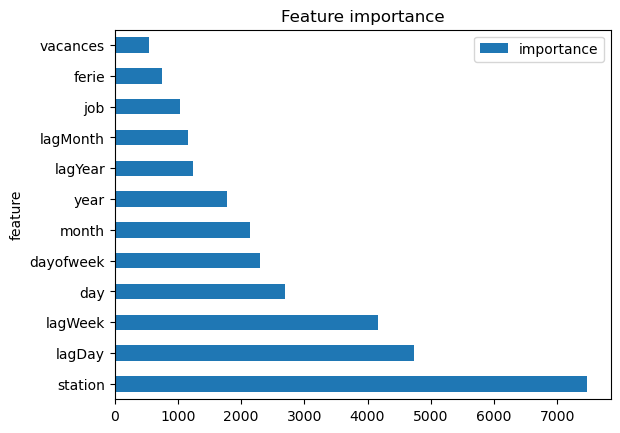

In [12]:
#feature importances
fi = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

In [13]:
# Predict using the trained model
y_pred = pd.DataFrame(index=X_test.index)
y_pred_vals = best_model.predict(X_test)
y_pred['y'] = np.clip(y_pred_vals, 0, None).astype(int) # Clip negative values to 0
y_pred.to_csv(file_path + 'y_pred_lightGBM5.csv')

Score: 95.11 (provavelmente um pouco menos)